In this notebook we will briefly cover the basics of the `pbmohpo` module implementing preferential Bayesian multi-objective hyperparameter optimization.
Core functionality is provided via the `run_pbmohpo_bench` function which takes a `YACS` configuration file specifying the benchmark problem looking like the following:

```yaml
PROBLEM:
  PROBLEM_TYPE: "yahpo"
  ID: "iaml_ranger"
  INSTANCE: "41146"
  OBJECTIVE_NAMES: ["auc", "ias"]

FIXED_HPS:
  REPLACE: ("replace", "TRUE")
  RESPECT_UNORDERED_FACTORS: ("respect.unordered.factors", "ignore")
  SPLITRULE: ("splitrule", "gini")
  NUM_RANDOM_SPLITS: ("num_random_splits", 1)
```

This config file specifies the benchmark `PROBLEM` and allows for fixing certain hyperparamters of the search space (`FIXED_HPS`).

`pbmohpo` provides exemplarly config files in the `experiments_configs` directory.
We can proceed to use the above config file via:

In [1]:
from main import run_pbmohpo_bench
from config import get_cfg_defaults

cfg = get_cfg_defaults() # this is somehwat weird? why are there some random defaults for different learners
cfg.merge_from_file('./experiment_configs/iaml_ranger.yaml')
cfg.freeze()
print(cfg)

BUDGET:
  BUDGET_AMOUNT: 50
  BUDGET_TYPE: iterations
DECISION_MAKER:
  DECISION_MAKER_TYPE: DecisionMaker
FIXED_HPS:
  BOOSTER: (None, None)
  NUM_IMPUTE_SELECTED_CPO: (None, None)
  NUM_RANDOM_SPLITS: ('num_random_splits', 1)
  REPL: (None, None)
  REPLACE: ('replace', 'TRUE')
  RESPECT_UNORDERED_FACTORS: ('respect.unordered.factors', 'ignore')
  SPLITRULE: ('splitrule', 'gini')
  TRAINSIZE: ('trainsize', 1)
OPTIMIZER:
  OPTIMIZER_TYPE: BO
PROBLEM:
  DIMENSIONS: 10
  ID: iaml_ranger
  INSTANCE: 41146
  OBJECTIVE_NAMES: ['auc', 'nf', 'ias']
  PROBLEM_TYPE: yahpo


We see that among `PROBLEM` and `FIXED_HPS` the resulting `YACS` config also includes parameters regarding the `BUDGET` and `OPTIMIZER` itself as well as the `DECISION MAKER`.
Running `run_pbmohpo_bench` on such a config will run the `OPTIMIZER` for the given `BUDGET` making use of the `DECISION_MAKER` to determine the utility function (i.e., in this example BO optimizing the utility scores provided by the decision maker for 50 function evaluation):

Testing YAHPO
id: iaml_ranger
instance: 41146
objectives: ['auc', 'nf', 'ias']
Running Bayesian Optimization on Utility Scores
Configuration space object:
  Hyperparameters:
    min.node.size, Type: UniformInteger, Range: [1, 100], Default: 50
    mtry.ratio, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    num.trees, Type: UniformInteger, Range: [1, 2000], Default: 1000
    sample.fraction, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.55

Decision Maker Preference Scores:
{'auc': 0.36193327838089256, 'nf': 0.34593361879026646, 'ias': 0.292133102828841}
Running [ 1|50]: Best utility: -6.646253967841423
Running [ 2|50]: Best utility: -6.590965193008098
Running [ 3|50]: Best utility: -6.590965193008098
Running [ 4|50]: Best utility: -6.590965193008098
Running [ 5|50]: Best utility: -6.578437672044086
Running [ 6|50]: Best utility: -6.578437672044086
Running [ 7|50]: Best utility: -6.578437672044086
Running [ 8|50]: Best utility: -6.578437672044086
Running [ 9|50]: Best utilit

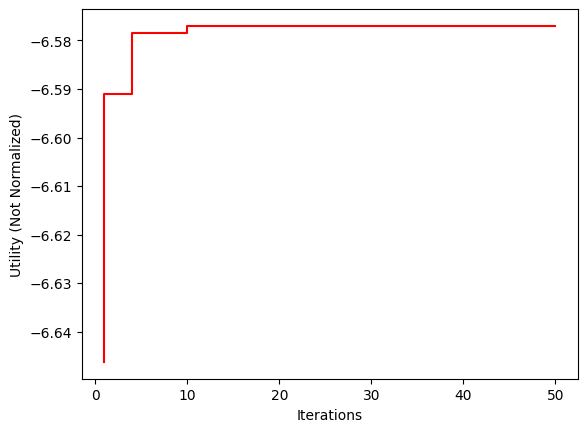

In [2]:
run_pbmohpo_bench(cfg, visualize=True)

We can see the optimization progress over time (which is also visualized in the figure).
Moreover, the best configuration found and the corresponding objectives are printed.
We can easily compare this to a random search: # Not meaningful because the decision maker is not fixed?

In [3]:
cfg.defrost()
cfg.merge_from_list(["OPTIMIZER.OPTIMIZER_TYPE", "RS"])
cfg.freeze()
print(cfg)

BUDGET:
  BUDGET_AMOUNT: 50
  BUDGET_TYPE: iterations
DECISION_MAKER:
  DECISION_MAKER_TYPE: DecisionMaker
FIXED_HPS:
  BOOSTER: (None, None)
  NUM_IMPUTE_SELECTED_CPO: (None, None)
  NUM_RANDOM_SPLITS: ('num_random_splits', 1)
  REPL: (None, None)
  REPLACE: ('replace', 'TRUE')
  RESPECT_UNORDERED_FACTORS: ('respect.unordered.factors', 'ignore')
  SPLITRULE: ('splitrule', 'gini')
  TRAINSIZE: ('trainsize', 1)
OPTIMIZER:
  OPTIMIZER_TYPE: RS
PROBLEM:
  DIMENSIONS: 10
  ID: iaml_ranger
  INSTANCE: 41146
  OBJECTIVE_NAMES: ['auc', 'nf', 'ias']
  PROBLEM_TYPE: yahpo


Testing YAHPO
id: iaml_ranger
instance: 41146
objectives: ['auc', 'nf', 'ias']
Running Random Search
Configuration space object:
  Hyperparameters:
    min.node.size, Type: UniformInteger, Range: [1, 100], Default: 50
    mtry.ratio, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    num.trees, Type: UniformInteger, Range: [1, 2000], Default: 1000
    sample.fraction, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.55

Decision Maker Preference Scores:
{'auc': 0.45500196869443876, 'nf': 0.2290074411043738, 'ias': 0.31599059020118736}
Running [ 1|50]: Best utility: -4.235689743834423
Running [ 2|50]: Best utility: -4.151202107330885
Running [ 3|50]: Best utility: -4.151202107330885
Running [ 4|50]: Best utility: -4.151202107330885
Running [ 5|50]: Best utility: -4.151202107330885
Running [ 6|50]: Best utility: -4.151202107330885
Running [ 7|50]: Best utility: -4.151202107330885
Running [ 8|50]: Best utility: -4.151202107330885
Running [ 9|50]: Best utility: -4.151202107330885
Run

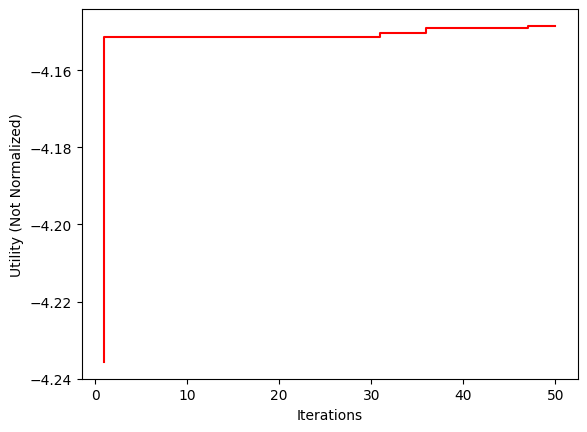

In [4]:
run_pbmohpo_bench(cfg, visualize=True)

`pbmohpo` also provides the `Benchmark` class that allows for working in a modular way relying on a `Problem`, an `Optimizer`, a `DecisionMaker` and a `budget` given as the number of function evaluations:

In [5]:
from pbmohpo.benchmark import Benchmark
from pbmohpo.problems.yahpo import YAHPO
from pbmohpo.optimizers.optimizer import PreferenceOptimizer
from pbmohpo.optimizers.random_search import PreferentialRandomSearch
from pbmohpo.decision_makers.decision_maker import DecisionMaker
from pbmohpo.utils import visualize_archives

fix_hps = {
    "trainsize": 1,
    "replace": "TRUE",
    "respect.unordered.factors": "ignore",
    "splitrule": "gini",
    "num_random_splits": 1,
}
prob = YAHPO(id="iaml_ranger", fix_hps=fix_hps, instance="41146", objective_names=["auc", "ias"])

opt = PreferentialRandomSearch(prob.get_config_space())  # why does this have a print output and other constructors do not

dm = DecisionMaker(objective_names=prob.get_objective_names())
print(dm.preferences)

Configuration space object:
  Hyperparameters:
    min.node.size, Type: UniformInteger, Range: [1, 100], Default: 50
    mtry.ratio, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    num.trees, Type: UniformInteger, Range: [1, 2000], Default: 1000
    sample.fraction, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.55
    trainsize, Type: UniformFloat, Range: [0.03, 1.0], Default: 0.525

{'auc': 0.07192519881446285, 'ias': 0.9280748011855371}


In [6]:
bench = Benchmark(prob, opt, dm, budget=50)
bench.run()

Running [ 2|50]: Best utility: 0.013331921622036863
Running [ 4|50]: Best utility: 0.024568045195520985
Running [ 6|50]: Best utility: 0.024568045195520985
Running [ 8|50]: Best utility: 0.04697195650783457
Running [10|50]: Best utility: 0.057458020524180836
Running [12|50]: Best utility: 0.057458020524180836
Running [14|50]: Best utility: 0.057458020524180836
Running [16|50]: Best utility: 0.057458020524180836
Running [18|50]: Best utility: 0.057458020524180836
Running [20|50]: Best utility: 0.057458020524180836
Running [22|50]: Best utility: 0.057458020524180836
Running [24|50]: Best utility: 0.057458020524180836
Running [26|50]: Best utility: 0.057458020524180836
Running [28|50]: Best utility: 0.057458020524180836
Running [30|50]: Best utility: 0.057458020524180836
Running [32|50]: Best utility: 0.057458020524180836
Running [34|50]: Best utility: 0.057458020524180836
Running [36|50]: Best utility: 0.057458020524180836
Running [38|50]: Best utility: 0.057458020524180836
Running [40|5

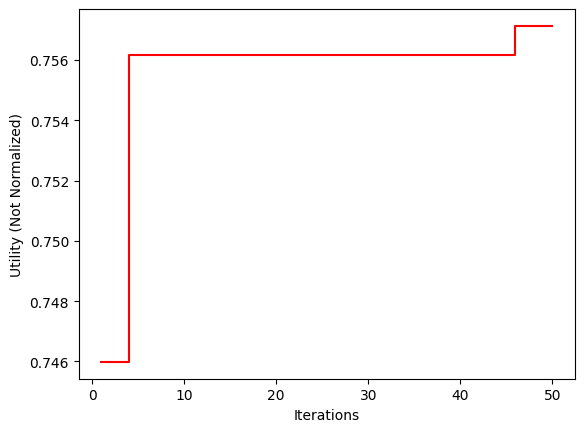

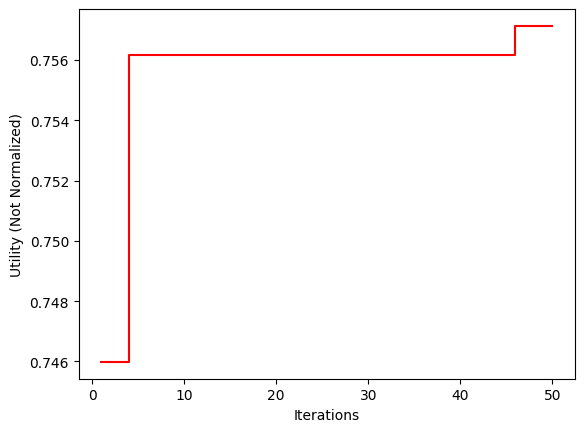

In [28]:
archive = (bench.archive.to_utility_archive() if issubclass(type(opt), PreferenceOptimizer) else bench.archive)
visualize_archives([archive])